In [198]:
import os
import random
from PIL import Image
from pathlib import Path
from timeit import default_timer as Timer
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset, Dataset
from torchinfo import summary
import wandb
import onnx
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from Scripts import engine

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cpu
0.21.0+cpu


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
data_path = Path("data/")
image_path = data_path/"CIFAKE"

def walk_trough_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories & {len(filenames)} images in {dirpath}.")

walk_trough_dir(image_path)

There are 2 directories & 0 images in data\CIFAKE.
There are 2 directories & 0 images in data\CIFAKE\test.
There are 0 directories & 10000 images in data\CIFAKE\test\FAKE.
There are 0 directories & 10000 images in data\CIFAKE\test\REAL.
There are 2 directories & 0 images in data\CIFAKE\train.
There are 0 directories & 50000 images in data\CIFAKE\train\FAKE.
There are 0 directories & 50000 images in data\CIFAKE\train\REAL.


In [9]:
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir, test_dir

(WindowsPath('data/CIFAKE/train'), WindowsPath('data/CIFAKE/test'))

FAKE


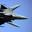

In [10]:
torch.manual_seed(42)

random_image_list = list(image_path.glob("*/*/*.jpg"))
random_img_path = random.choice(random_image_list)
image_class = random_img_path.parent.stem
random_img = Image.open(random_img_path)

print(image_class)
random_img

In [11]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop((224, 224), scale=(0.1,1)),
    transforms.ToTensor()
])

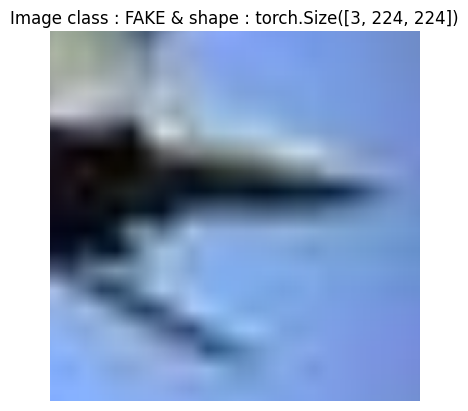

In [12]:
transformed_image = transform(random_img)

plt.figure()
plt.imshow(transformed_image.permute(1,2,0))
plt.title(f"Image class : {image_class} & shape : {transformed_image.shape}")
plt.axis(False);

In [13]:
class_names = ["FAKE", "REAL"]
class_dict = {"FAKE": 0,
              "REAL": 1}

In [14]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [15]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform= transform,
                                  target_transform= None)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform= test_transform)

In [16]:
len(train_data), len(test_data)

(100000, 20000)

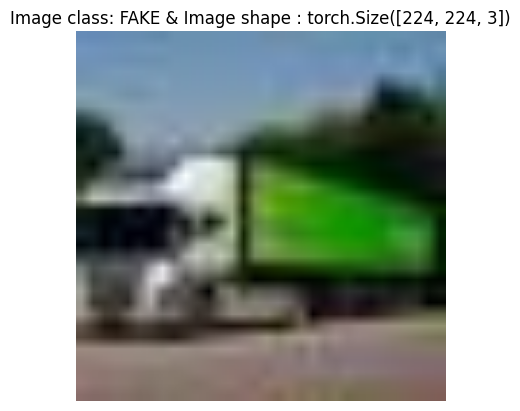

In [17]:
random_idx = random.randint(0, 20000)
plt.imshow(test_data[random_idx][0].permute(1,2,0))
plt.title(f"Image class: {class_names[test_data[random_idx][1]]} & Image shape : {test_data[random_idx][0].permute(1,2,0).shape}")
plt.axis(False);

In [79]:
ss = list(range(0, 1250))
len(ss)

1250

In [78]:
ss1 = list(range(50000, 51250))
len(ss1)

1250

In [83]:
def create_subset(dataset, num_of_datasets, size_of_datasets):
    """
    This will create n no. of subsets of the given data

    Args:
        dataset: The original dataset.
        num_subsets: Number of subsets to create.
        subset_size: Number of samples in each subset.
    
    Returns:
        A list of Subset objects.
    """
    subsets = []
    for i in range(num_of_datasets):
        start_idx = i * int(size_of_datasets / 2) 
        end_idx = start_idx + int(size_of_datasets / 2)

        start_idx_2 = start_idx + int(len(dataset) / 2)
        end_idx_2 = end_idx + int(len(dataset) / 2)

        subset_indices_1 = list(range(start_idx, end_idx))
        subset_indices_2 = list(range(start_idx_2, end_idx_2))
        subset_indices = subset_indices_1 + subset_indices_2
        random.shuffle(subset_indices)
        
        subsets.append(Subset(dataset, subset_indices))

    return subsets

In [84]:
train_subset = create_subset(train_data, 40, 2500)
test_subset = create_subset(test_data, 40, 500)

img, label = next(iter(test_subset[0]))
img

tensor([[[0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0471],
         [0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0471],
         [0.0588, 0.0588, 0.0588,  ..., 0.0471, 0.0471, 0.0471],
         ...,
         [0.4431, 0.4431, 0.4431,  ..., 0.1922, 0.1922, 0.1922],
         [0.4431, 0.4431, 0.4431,  ..., 0.1922, 0.1922, 0.1922],
         [0.4431, 0.4431, 0.4431,  ..., 0.1922, 0.1922, 0.1922]],

        [[0.1529, 0.1529, 0.1529,  ..., 0.1294, 0.1294, 0.1294],
         [0.1529, 0.1529, 0.1529,  ..., 0.1294, 0.1294, 0.1294],
         [0.1529, 0.1529, 0.1529,  ..., 0.1294, 0.1294, 0.1294],
         ...,
         [0.4549, 0.4549, 0.4549,  ..., 0.4275, 0.4275, 0.4275],
         [0.4549, 0.4549, 0.4549,  ..., 0.4275, 0.4275, 0.4275],
         [0.4549, 0.4549, 0.4549,  ..., 0.4275, 0.4275, 0.4275]],

        [[0.0510, 0.0510, 0.0510,  ..., 0.0549, 0.0549, 0.0549],
         [0.0510, 0.0510, 0.0510,  ..., 0.0549, 0.0549, 0.0549],
         [0.0510, 0.0510, 0.0510,  ..., 0.0549, 0.0549, 0.

In [20]:
len(train_subset), len(train_subset[0]),len(train_subset[0][0]), len(train_subset[0][0][0]), len(train_subset[0][0][0][0])

(40, 2500, 2, 3, 224)

In [122]:
BATCH_SIZE = 50

train_dataloader_subsets = [DataLoader(subset, BATCH_SIZE, shuffle= True) for subset in train_subset]
test_dataloader_subsets = [DataLoader(subset, BATCH_SIZE) for subset in test_subset]

train_dataloader_subsets[0]

In [123]:
for batch, (img, label) in enumerate(test_dataloader_subsets[0]):
    print(batch)

0
1
2
3
4
5
6
7
8
9


In [124]:
next(iter(test_dataloader_subsets))

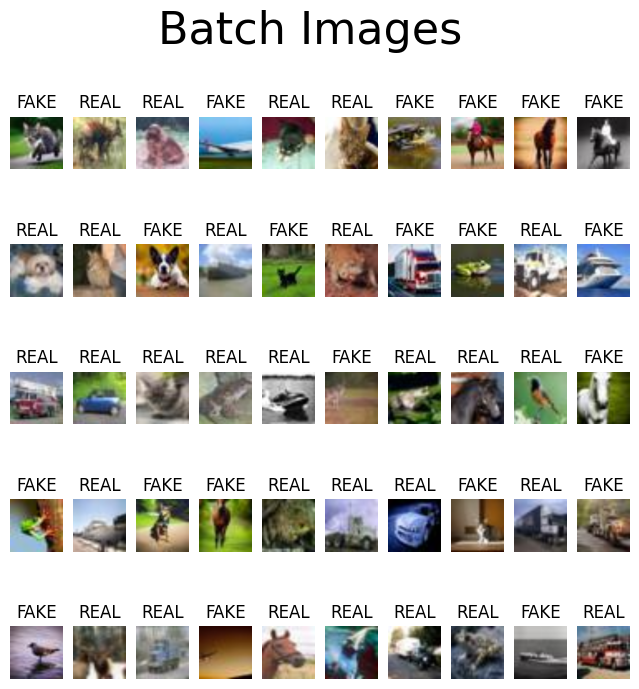

In [126]:
fig = plt.figure(figsize=(8,8))

fig.suptitle("Batch Images", fontsize=32)
rows, columns = 5, 10
for batch_idx, (img, label) in enumerate(test_dataloader_subsets[0]):
    if (batch_idx < 1):
        for i in range(1, rows * columns + 1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(img[i-1].permute(1,2,0))
            plt.title(class_names[int(label[i-1])], fontsize=12)
            plt.axis(False);


In [ ]:
efficientb0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efficientb0_weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [241]:
efficientb0_model = torchvision.models.efficientnet_b0(weights= efficientb0_weights).to(device)
efficientb0_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [242]:
summary(model= efficientb0_model,
        input_size= (25,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [25, 3, 224, 224]         [25, 1000]                --                        True
├─Sequential: 1-1                                       [25, 3, 224, 224]         [25, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [25, 3, 224, 224]         [25, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [25, 3, 224, 224]         [25, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                            [25, 32, 112, 112]        [25, 32, 112, 112]        64                        True
│    │    └─SiLU: 3-3                                   [25, 32, 112, 112]        [25, 32, 112, 112]        --                        --
│    └─Sequential: 2-2  

In [243]:
efficientb0_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [244]:
for parameter in efficientb0_model.features[:-2].parameters():
    parameter.requires_grad = False

efficientb0_model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace= True),
    nn.Linear(in_features=1280, out_features= 2, bias= True)
)

summary(model= efficientb0_model,
        input_size= (25,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [25, 3, 224, 224]         [25, 2]                   --                        Partial
├─Sequential: 1-1                                       [25, 3, 224, 224]         [25, 1280, 7, 7]          --                        Partial
│    └─Conv2dNormActivation: 2-1                        [25, 3, 224, 224]         [25, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [25, 3, 224, 224]         [25, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [25, 32, 112, 112]        [25, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [25, 32, 112, 112]        [25, 32, 112, 112]        --                        --
│    └─Sequenti

In [185]:
from itertools import chain

# Combine iterators from both DataLoaders
combined_iterator = chain(iter(test_dataloader_subsets[0]), iter(test_dataloader_subsets[1]), iter(test_dataloader_subsets[2]), iter(test_dataloader_subsets[3]))

for batch, (img, label) in enumerate(combined_iterator):
    print(batch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [214]:
for i in range(11):
    iterator = chain(iter(iterator),iter(test_dataloader_subsets[i]))
for batch, (img, label) in enumerate(iterator):
    print(batch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


In [174]:
len(train_dataloader_subsets)

40

In [245]:
class empty_dataset(Dataset):

    def __init__(self):
        pass

    def __len__(self):
        return 0
    
    def __getitem__(self, idx):
        return IndexError("This dataset is empty!")

In [246]:
def amount_of_data(dataloader_subsets,
                   multiple,
                   batch_size):
    total_subsets = len(dataloader_subsets)

    concatdataset = empty_dataset()
    
    if multiple > total_subsets:
        raise ValueError(
            "multiple greater than the number of subsets"
        )
    else:
        for i in range(multiple):
            dataloader_dataset = dataloader_subsets[i].dataset
            concatdataset = ConcatDataset([concatdataset, dataloader_dataset])
        dataloaders = DataLoader(concatdataset, batch_size= batch_size, shuffle= True)
        
    return dataloaders

In [209]:
len(train_dataloader_subsets[0])

50

In [226]:
subset_2_dataloader = amount_of_data(test_dataloader_subsets, 2, 50)
len(subset_2_dataloader)

20

In [247]:
config = {
    "batch_size" : 50,
    "learning_rate" : 0.01,
    "epochs" : 10,
    "ARCHITECHTURE" : "EfficientNet_B0_unfreezed_last_2_layer",
}

with wandb.init(project="AI_Image_Classification", name="50_0.01-0.001_10_subs_2_last_2_layer_unfreeze", settings=wandb.Settings(symlink=False)) as run:
    learning_rate_classifier = 0.01
    learning_rate_unfrozenlayer = 0.001
    batch_size = 50
    epochs = 10
    subsetdata_amount = 2

    run.config.learning_rate = learning_rate_classifier
    run.config.learning_rate_unfrozenlayer = learning_rate_unfrozenlayer
    run.config.batch_size = batch_size
    run.config.epochs = epochs
    run.config.subsetdata_amount = subsetdata_amount
    run.config.ARCHITECHTURE = "EfficientNet_B0_unfreezed_last_2_layer"

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam([
        {"params": efficientb0_model.classifier.parameters(), "lr" : learning_rate_classifier},
        {"params": efficientb0_model.features[-2:].parameters(), "lr" : learning_rate_unfrozenlayer}
    ], weight_decay= 1e-4)

    results = { 
            "train loss": [],
            "train acc": [],
            "test loss": [],
            "test acc": []
        }
    
    train_subsetdata_amount_dataloader = amount_of_data(train_dataloader_subsets, subsetdata_amount, batch_size)
    test_subsetdata_amount_dataloader = amount_of_data(test_dataloader_subsets, subsetdata_amount, batch_size)

    for epoch in tqdm(range(epochs)):

        # Training Loop
        train_loss, train_acc, y_train_actual, y_train_predicted = engine.train_loop(model= efficientb0_model,
                                                                                     train_dataloader= train_subsetdata_amount_dataloader,
                                                                                     loss_fn= loss_fn,
                                                                                     optimizer= optimizer,
                                                                                     device= device)
        

        # Testing Loop
        test_loss, test_acc, y_test_actual, y_test_predicted = engine.test_loop(model= efficientb0_model,
                                                                                test_dataloader= test_subsetdata_amount_dataloader,
                                                                                loss_fn= loss_fn,
                                                                                device= device)

        results["train loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        run.log({
            "epoch" : epoch + 1,
            "train_loss" : train_loss,
            "train_accuracy" : train_acc,
            "test_loss" : test_loss,
            "test_accuracy" : test_acc,
        })

        print(f"Epoch {epoch + 1}/{epochs}: train loss: {train_loss:.4f} |\ntrain accuracy: {train_acc:.4f} |\ntest loss: {test_loss:.4f} |\ntest accuracy: {test_acc:.4f}")

        torch.onnx.export(
            efficientb0_model,
            torch.randn(1,3,224,224),
            "efficientnetb0.onnx",
            input_names = ["input"],
            output_names = ["output"],
        )
    
    run.log_artifact("efficientnetb0.onnx", name= "50_0.01-0.001_10_subs_2_last_2_layer_unfreeze", type= "model")

    print("Model training completed.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: train loss: 0.5254 |
train accuracy: 0.7630 |
test loss: 0.2981 |
test accuracy: 0.8640


 10%|█         | 1/10 [07:37<1:08:36, 457.34s/it]

Epoch 2/10: train loss: 0.4051 |
train accuracy: 0.8194 |
test loss: 0.3300 |
test accuracy: 0.8590


 20%|██        | 2/10 [15:27<1:01:57, 464.70s/it]

Epoch 3/10: train loss: 0.3959 |
train accuracy: 0.8230 |
test loss: 0.3430 |
test accuracy: 0.8620


 30%|███       | 3/10 [23:26<55:00, 471.54s/it]  

Epoch 4/10: train loss: 0.3657 |
train accuracy: 0.8388 |
test loss: 0.3173 |
test accuracy: 0.8750


 40%|████      | 4/10 [30:09<44:25, 444.27s/it]

Epoch 5/10: train loss: 0.3569 |
train accuracy: 0.8398 |
test loss: 0.2901 |
test accuracy: 0.8780


 50%|█████     | 5/10 [36:00<34:12, 410.53s/it]

Epoch 6/10: train loss: 0.3356 |
train accuracy: 0.8544 |
test loss: 0.2561 |
test accuracy: 0.8950


 60%|██████    | 6/10 [43:59<28:56, 434.09s/it]

Epoch 7/10: train loss: 0.3317 |
train accuracy: 0.8536 |
test loss: 0.3743 |
test accuracy: 0.8510


 70%|███████   | 7/10 [49:56<20:26, 408.73s/it]

Epoch 8/10: train loss: 0.3076 |
train accuracy: 0.8666 |
test loss: 0.2716 |
test accuracy: 0.8950


 80%|████████  | 8/10 [55:46<12:59, 389.95s/it]

Epoch 9/10: train loss: 0.3150 |
train accuracy: 0.8652 |
test loss: 0.5145 |
test accuracy: 0.8170


 90%|█████████ | 9/10 [1:01:24<06:13, 373.87s/it]

Epoch 10/10: train loss: 0.2922 |
train accuracy: 0.8746 |
test loss: 0.2988 |
test accuracy: 0.8830


100%|██████████| 10/10 [1:08:59<00:00, 413.93s/it]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Model training completed.


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▅▅▅▆▆█▄█▁▇
test_loss,▂▃▃▃▂▁▄▁█▂
train_accuracy,▁▅▅▆▆▇▇▇▇█
train_loss,█▄▄▃▃▂▂▁▂▁
epoch,10
test_accuracy,0.883
test_loss,0.2988
train_accuracy,0.8746
train_loss,0.29222


In [281]:
classification_report(y_train_actual, y_train_predicted)

'              precision    recall  f1-score   support\n\n           0       0.80      0.79      0.79      2500\n           1       0.79      0.80      0.79      2500\n\n    accuracy                           0.79      5000\n   macro avg       0.79      0.79      0.79      5000\nweighted avg       0.79      0.79      0.79      5000\n'

In [282]:
classification_report(y_test_actual, y_test_predicted)

'              precision    recall  f1-score   support\n\n           0       0.73      0.94      0.82       500\n           1       0.91      0.64      0.76       500\n\n    accuracy                           0.79      1000\n   macro avg       0.82      0.79      0.79      1000\nweighted avg       0.82      0.79      0.79      1000\n'

In [265]:
cr = classification_report(y_test_actual, y_test_predicted, output_dict= True)
cr["0"]["recall"]

0.794

In [283]:
cm = confusion_matrix(y_train_actual, y_train_predicted)
cm

array([[1976,  524],
       [ 506, 1994]])

In [284]:
cm_test = confusion_matrix(y_test_actual, y_test_predicted)
cm_test

array([[470,  30],
       [178, 322]])

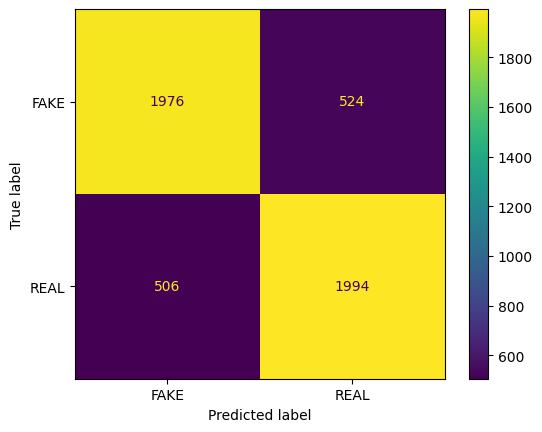

In [285]:
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot();

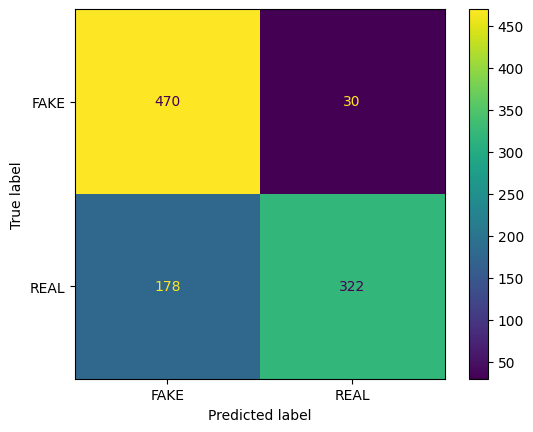

In [286]:
disp = ConfusionMatrixDisplay(cm_test, display_labels= class_names)
disp.plot();

In [271]:
efficientb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
efficientb2_weights

EfficientNet_B2_Weights.IMAGENET1K_V1

In [272]:
auto_transform = efficientb2_weights.transforms()
auto_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [274]:
efficientb2_model = torchvision.models.efficientnet_b2(weights= efficientb2_weights).to(device)
efficientb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [275]:
summary(efficientb2_model,
        input_size= (50, 3, 224, 224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [50, 3, 224, 224]         [50, 1000]                --                        True
├─Sequential: 1-1                                       [50, 3, 224, 224]         [50, 1408, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [50, 3, 224, 224]         [50, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [50, 3, 224, 224]         [50, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                            [50, 32, 112, 112]        [50, 32, 112, 112]        64                        True
│    │    └─SiLU: 3-3                                   [50, 32, 112, 112]        [50, 32, 112, 112]        --                        --
│    └─Sequential: 2-2  

In [276]:
efficientb2_model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [279]:
for parameter in efficientb2_model.features[:-2].parameters():
    parameter.requires_grad = False

efficientb2_model.classifier = nn.Sequential(
    nn.Dropout(p= 0.3, inplace= True),
    nn.Linear(in_features= 1408, out_features= 2, bias= True)
)

summary(efficientb2_model,
        input_size= (50, 3, 224, 224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [50, 3, 224, 224]         [50, 2]                   --                        Partial
├─Sequential: 1-1                                       [50, 3, 224, 224]         [50, 1408, 7, 7]          --                        Partial
│    └─Conv2dNormActivation: 2-1                        [50, 3, 224, 224]         [50, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [50, 3, 224, 224]         [50, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [50, 32, 112, 112]        [50, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [50, 32, 112, 112]        [50, 32, 112, 112]        --                        --
│    └─Sequenti

In [280]:
config = {
    "batch_size" : 50,
    "learning_rate" : 0.01,
    "epochs" : 10,
    "ARCHITECHTURE" : "efficientnetb2_last_2_layer_unfreeze",
}

with wandb.init(project="AI_Image_Classification", name="50_0.01-0.001_10_subs_2_effnetb2_last_2_unfreeze", settings=wandb.Settings(symlink=False)) as run:
    learning_rate_classifier = 0.01
    learning_rate_unfrozenlayer = 0.001
    batch_size = 50
    epochs = 10
    subsetdata_amount = 2

    run.config.learning_rate = learning_rate_classifier
    run.config.learning_rate_unfrozenlayer = learning_rate_unfrozenlayer
    run.config.batch_size = batch_size
    run.config.epochs = epochs
    run.config.subsetdata_amount = subsetdata_amount
    run.config.ARCHITECHTURE = "efficientnetb2_last_2_layer_unfreeze"

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam([
        {"params": efficientb2_model.classifier.parameters(), "lr" : learning_rate_classifier},
        {"params": efficientb2_model.features[-1:].parameters(), "lr" : learning_rate_unfrozenlayer}
    ], weight_decay= 1e-4)

    results = { 
            "train loss": [],
            "train acc": [],
            "test loss": [],
            "test acc": []
        }
    
    train_subsetdata_amount_dataloader = amount_of_data(train_dataloader_subsets, subsetdata_amount, batch_size)
    test_subsetdata_amount_dataloader = amount_of_data(test_dataloader_subsets, subsetdata_amount, batch_size)

    for epoch in tqdm(range(epochs)):

        # Training Loop
        train_loss, train_acc, y_train_actual, y_train_predicted = engine.train_loop(model= efficientb2_model,
                                                                                     train_dataloader= train_subsetdata_amount_dataloader,
                                                                                     loss_fn= loss_fn,
                                                                                     optimizer= optimizer,
                                                                                     device= device)
        

        # Testing Loop
        test_loss, test_acc, y_test_actual, y_test_predicted = engine.test_loop(model= efficientb2_model,
                                                                                test_dataloader= test_subsetdata_amount_dataloader,
                                                                                loss_fn= loss_fn,
                                                                                device= device)

        results["train loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        run.log({
            "epoch" : epoch + 1,
            "train_loss" : train_loss,
            "train_accuracy" : train_acc,
            "test_loss" : test_loss,
            "test_accuracy" : test_acc,
        })

        print(f"Epoch {epoch + 1}/{epochs}: train loss: {train_loss:.4f} |\ntrain accuracy: {train_acc:.4f} |\ntest loss: {test_loss:.4f} |\ntest accuracy: {test_acc:.4f}")

        torch.onnx.export(
            efficientb2_model,
            torch.randn(1,3,224,224),
            "efficientnetb2.onnx",
            input_names = ["input"],
            output_names = ["output"],
        )
    
    run.log_artifact("efficientnetb2.onnx", name= "50_0.01-0.001_10_subs_2_effnetb2_last_2_unfreeze", type= "model")

    print("Model training completed.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: train loss: 0.6519 |
train accuracy: 0.7136 |
test loss: 0.5033 |
test accuracy: 0.7760


 10%|█         | 1/10 [10:40<1:36:07, 640.89s/it]

Epoch 2/10: train loss: 0.6125 |
train accuracy: 0.7408 |
test loss: 0.4718 |
test accuracy: 0.7980


 20%|██        | 2/10 [20:37<1:21:59, 614.99s/it]

Epoch 3/10: train loss: 0.5924 |
train accuracy: 0.7574 |
test loss: 0.4197 |
test accuracy: 0.8030


 30%|███       | 3/10 [29:25<1:07:05, 575.10s/it]

Epoch 4/10: train loss: 0.5716 |
train accuracy: 0.7638 |
test loss: 0.5499 |
test accuracy: 0.7930


 40%|████      | 4/10 [38:22<55:59, 559.92s/it]  

Epoch 5/10: train loss: 0.5698 |
train accuracy: 0.7750 |
test loss: 0.4647 |
test accuracy: 0.8020


 50%|█████     | 5/10 [47:26<46:11, 554.40s/it]

Epoch 6/10: train loss: 0.5357 |
train accuracy: 0.7800 |
test loss: 0.5183 |
test accuracy: 0.7970


 60%|██████    | 6/10 [57:53<38:36, 579.04s/it]

Epoch 7/10: train loss: 0.5218 |
train accuracy: 0.7804 |
test loss: 0.5674 |
test accuracy: 0.7710


 70%|███████   | 7/10 [1:06:15<27:41, 553.91s/it]

Epoch 8/10: train loss: 0.4995 |
train accuracy: 0.7956 |
test loss: 0.4793 |
test accuracy: 0.8080


 80%|████████  | 8/10 [1:14:09<17:36, 528.27s/it]

Epoch 9/10: train loss: 0.5316 |
train accuracy: 0.7830 |
test loss: 0.5070 |
test accuracy: 0.7990


 90%|█████████ | 9/10 [1:23:12<08:53, 533.00s/it]

Epoch 10/10: train loss: 0.4793 |
train accuracy: 0.7940 |
test loss: 0.5123 |
test accuracy: 0.7920


100%|██████████| 10/10 [1:31:36<00:00, 549.60s/it]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Model training completed.


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▂▆▇▅▇▆▁█▆▅
test_loss,▅▃▁▇▃▆█▄▅▅
train_accuracy,▁▃▅▅▆▇▇█▇█
train_loss,█▆▆▅▅▃▃▂▃▁
epoch,10
test_accuracy,0.792
test_loss,0.51235
train_accuracy,0.794
train_loss,0.47934
